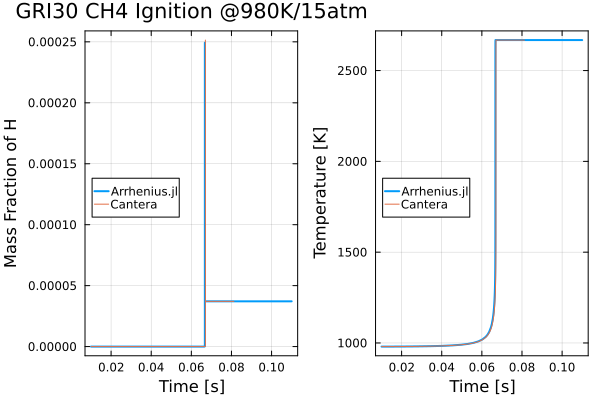

  1.548571 seconds (3.11 M allocations: 315.133 MiB, 3.88% gc time, 87.43% compilation time: 100% of which was recompilation)


In [8]:
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Sundials
using Plots
using DelimitedFiles
using Profile

solver = TRBDF2()
# solver = KenCarp4()
# solver   = Rodas5()    # try 5th-order implicit Runge-Kutta

# solver = CVODE_BDF()


cantera_data = readdlm("ignition.dat")
ct_ts = cantera_data[:, 1]
ct_T = cantera_data[:, 2]
ct_Y = cantera_data[:, 3:end]

gas = CreateSolution("../../mechanism/mechanism_julia/gri12.yaml")
ns = gas.n_species

T0 = 980.0
P = one_atm * 15.0

X0 = zeros(ns);
X0[species_index(gas, "CH4")] = 1.0 / 2.0
X0[species_index(gas, "O2")] = 1.0
X0[species_index(gas, "N2")] = 3.76
X0 = X0 ./ sum(X0);
Y0 = X2Y(gas, X0, dot(X0, gas.MW));

# Y0 = ones(ns) ./ns
u0 = vcat(Y0, T0)
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1.0 / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    # qdot = wdot_func(gas.reaction, T, C, S0, h_mole; get_qdot=true)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

tspan = [0.0, 0.1];
prob = ODEProblem(dudt!, u0, tspan);
@time sol = solve(prob, solver, reltol = 1e-6, abstol = 1e-9)

tmin = 1e-2

plt = plot(
  sol.t .+ tmin,
  sol[species_index(gas, "H"), :],
  lw = 2,
  label = "Arrhenius.jl",
)
plot!(plt, ct_ts .+ tmin, ct_Y[:, species_index(gas, "H")],
      label = "Cantera")
ylabel!(plt, "Mass Fraction of H")
xlabel!(plt, "Time [s]")

pltT = plot(sol.t .+ tmin, sol[end, :],
            lw = 2, label = "Arrhenius.jl")
plot!(pltT, ct_ts .+ tmin, ct_T, label = "Cantera")
ylabel!(pltT, "Temperature [K]")
xlabel!(pltT, "Time [s]")

title!(plt, "GRI30 CH4 Ignition @980K/15atm")

pltsum = plot(plt, pltT,
              xscale = :identity,
              legend = :left,
              framestyle = :box)
display(pltsum)